In [1]:
#v2
#7/11/2018

dataname="bladder_te_filt"

desired_mask_mpp = 16
model_mpp = 0.5 # MPP of patches to be fed into model

patch_size=256 #size of the tiles to extract and save in the database, must be >= to training size
stride_size = patch_size
test_set_size=.2 # what percentage of the dataset should be used as a held out validation/testing set
resize=1 #resize input images
class_names=[0,1] #what classes we expect to have in the data, here we have only 2 classes but we could add additional classes and/or specify an index from which we would like to ignore

#-----Note---
#One should likely make sure that  (nrow+mirror_pad_size) mod patch_size == 0, where nrow is the number of rows after resizing
#so that no pixels are lost (any remainer is ignored)


In [2]:
import torch
import tables

import os,sys
import glob

import PIL
import numpy as np
import scipy

import cv2
import matplotlib.pyplot as plt

from sklearn import model_selection
import sklearn.feature_extraction.image
import random

sys.path.insert(1,'/mnt/data/home/pjl54/WSI_handling')
import wsi

import tqdm

seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the cross validation setup
random.seed(seed) # set the seed
print(f"random seed (note down for reproducibility): {seed}")

random seed (note down for reproducibility): 798764965297604225


In [3]:
from unet import UNet

te_model = '/mnt/data/home/pjl54/bladder/bladderTE_1mpp_256p.pth'
te_mpp = 1;
te_device = 2
checkpoint = torch.load(te_model, map_location=lambda storage, loc: storage) #load checkpoint to CPU and then put to device https://discuss.pytorch.org/t/saving-and-loading-torch-models-on-2-machines-with-different-number-of-gpu-devices/6666
model = UNet(n_classes=checkpoint["n_classes"], in_channels=checkpoint["in_channels"],
             padding=checkpoint["padding"], depth=checkpoint["depth"], wf=checkpoint["wf"],
             up_mode=checkpoint["up_mode"], batch_norm=checkpoint["batch_norm"]).to(te_device)
model.load_state_dict(checkpoint["model_dict"])
model.eval()

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 3

In [4]:
img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved, this indicates that images will be saved as unsigned int 8 bit, i.e., [0,255]
filenameAtom = tables.StringAtom(itemsize=255) #create an atom to store the filename of the image, just incase we need it later, 

In [5]:
grade_key = {}
with open('/mnt/data/home/pjl54/bladder/densenet/blad_grade_key.txt') as file:
    for line in file:
        (patient, label) = line.split()
        grade_key[patient] = int(label)

In [6]:
all_files = []
for patient in grade_key.keys():
    if os.path.exists('/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/' + patient):
        all_files.append('/mnt/ccipd_data/UH_Bladder_Cancer_Project/Blad170830/' + patient)
    else:
        all_files.append('/mnt/ccipd_data/UH_Bladder_Histology/May_2019/Ventana/' + patient)

# all_files=glob.glob(r'/mnt/data/home/pjl54/pesoProstateSE/imgs/*training_mask.tif')

#create training and validation stages and split the files appropriately between them
phases={}
phases["train"],phases["val"]=next(iter(model_selection.ShuffleSplit(n_splits=1,test_size=test_set_size).split(all_files)))

#specify that we'll be saving 2 different image types to the database, an image and its associated masked
imgtypes=["imgs","labels"]

In [7]:
storage={} #holder for future pytables
block_shape= np.array((patch_size,patch_size,3))

filters=tables.Filters(complevel=6, complib='zlib') #we can also specify filters, such as compression, to improve storage speed

for phase in phases.keys(): #now for each of the phases, we'll loop through the files
    print(phase)
    files = [all_files[k] for k in phases[phase]]
    
    rscs = [[] for i in range(0,len(files))]    

    osis = [wsi.wsi(img_fname = file, xml_fname = file.split('.tif')[0]+'.xml') for file in files]

    totals=np.zeros(len(class_names)) # we can to keep counts of all the classes in for in particular training, since we 

    hdf5_file = tables.open_file(f"./{dataname}_{phase}.pytable", mode='w') #open the respective pytable
    storage["filenames"] = hdf5_file.create_earray(hdf5_file.root, 'filenames', filenameAtom, (0,)) #create the array for storage
    
    storage["imgs"]= hdf5_file.create_earray(hdf5_file.root, "imgs", img_dtype,  
                                                  shape=np.append([0],block_shape), 
                                                  chunkshape=np.append([1],block_shape),
                                                  filters=filters)

    storage["labels"]= hdf5_file.create_earray(hdf5_file.root, "labels", img_dtype,  
                                              shape=[0], 
                                              chunkshape=[1],
                                              filters=filters)


    for index, wsi_img in tqdm.tqdm(enumerate(osis)):        

        stride_size_converted = wsi_img.get_coord_at_mpp(stride_size,input_mpp=wsi_img["mpps"][0],output_mpp=desired_mask_mpp)

        [mask_small, resize_factor] = wsi_img.mask_out_annotation(desired_mpp=desired_mask_mpp,colors_to_use=None)            

        mask_small = mask_small[list(range(0,np.shape(mask_small)[0],stride_size_converted)),:]            
        mask_small = mask_small[:,list(range(0,np.shape(mask_small)[1],stride_size_converted))]            

        [rs,cs]=(mask_small>0).nonzero()
        rs = [r*stride_size_converted for r in rs]
        cs = [c*stride_size_converted for c in cs]

        rs = [wsi_img.get_coord_at_mpp(r,wsi_img["mpps"][0],desired_mask_mpp) for r in rs]
        cs = [wsi_img.get_coord_at_mpp(c,wsi_img["mpps"][0],desired_mask_mpp) for c in cs]

        goods = np.ones(np.shape(rs)[0])
        for k in range(0,np.shape(rs)[0]):

#             a = wsi_img.get_tile(coords=(cs[k],rs[k]),wh=(1,1),desired_mpp=desired_mask_mpp)
#             if((np.sum(a>220)/np.size(a))>0.50):                
#                 goods[k] = False             
#             else:                                
            te_tile = wsi_img.get_tile(coords=(cs[k],rs[k]),wh=(int(patch_size*(te_mpp/model_mpp)),int(patch_size*(te_mpp/model_mpp))),desired_mpp=te_mpp)
            if((np.sum(te_tile[:,:,1]>220)/np.size(te_tile[:,:,1]))>0.30):
                goods[k] = False
            else:    
                arr_out_gpu = torch.from_numpy(np.expand_dims(te_tile,axis=0).transpose(0,3,1,2) / 255).type('torch.FloatTensor').to(te_device)
                output_batch = model(arr_out_gpu)
                output = output_batch[0,:,:,:].detach().cpu().numpy()
                te_map = output.argmax(axis=0)==1

                if((np.sum(te_map)/np.size(te_map))<0.50):                
                    goods[k] = False

        cs = [c for idx,c in enumerate(cs) if goods[idx]]
        rs = [r for idx,r in enumerate(rs) if goods[idx]]
        rscs[index]=(cs,rs)            
        
        classid = grade_key[wsi_img['img_fname'].split('/')[-1]]
        totals[classid]+=1


    patch_counts = [np.shape(k)[1] for k in rscs]        
#     patch_counts[0] = patch_counts[0] - 1   
    adds = [1] + patch_counts
    adds = np.cumsum(adds)
#     storage["img"] = np.ones([sum(patch_counts),patch_size,patch_size,3],dtype=np.uint8)
#     storage["mask"] = np.ones([sum(patch_counts),patch_size,patch_size],dtype=np.uint8)

    for index, wsi_img in tqdm.tqdm(enumerate(osis)):
        img_label = grade_key[wsi_img['img_fname'].split('/')[-1]]
        for rcidx in range(0,patch_counts[index]-1):            

            img = wsi_img.get_tile(desired_mpp=model_mpp,coords=(rscs[index][0][rcidx],rscs[index][1][rcidx]),wh=(patch_size,patch_size))        


            storage["imgs"].append(img.reshape(-1,patch_size,patch_size,3))
            storage["labels"].append([img_label])

        storage["filenames"].append([files[index] for x in range(patch_counts[index]-1)]) #add the filename to the storage array

    #lastely, we should store the number of pixels
    npixels=hdf5_file.create_carray(hdf5_file.root, 'classsizes', tables.Atom.from_dtype(totals.dtype), totals.shape)
    npixels[:]=totals
    hdf5_file.close()

train


40it [40:57, 61.44s/it] 
40it [08:27, 12.68s/it]


val


10it [10:42, 64.27s/it]
10it [02:34, 15.50s/it]


ClosedNodeError: the node object is closed

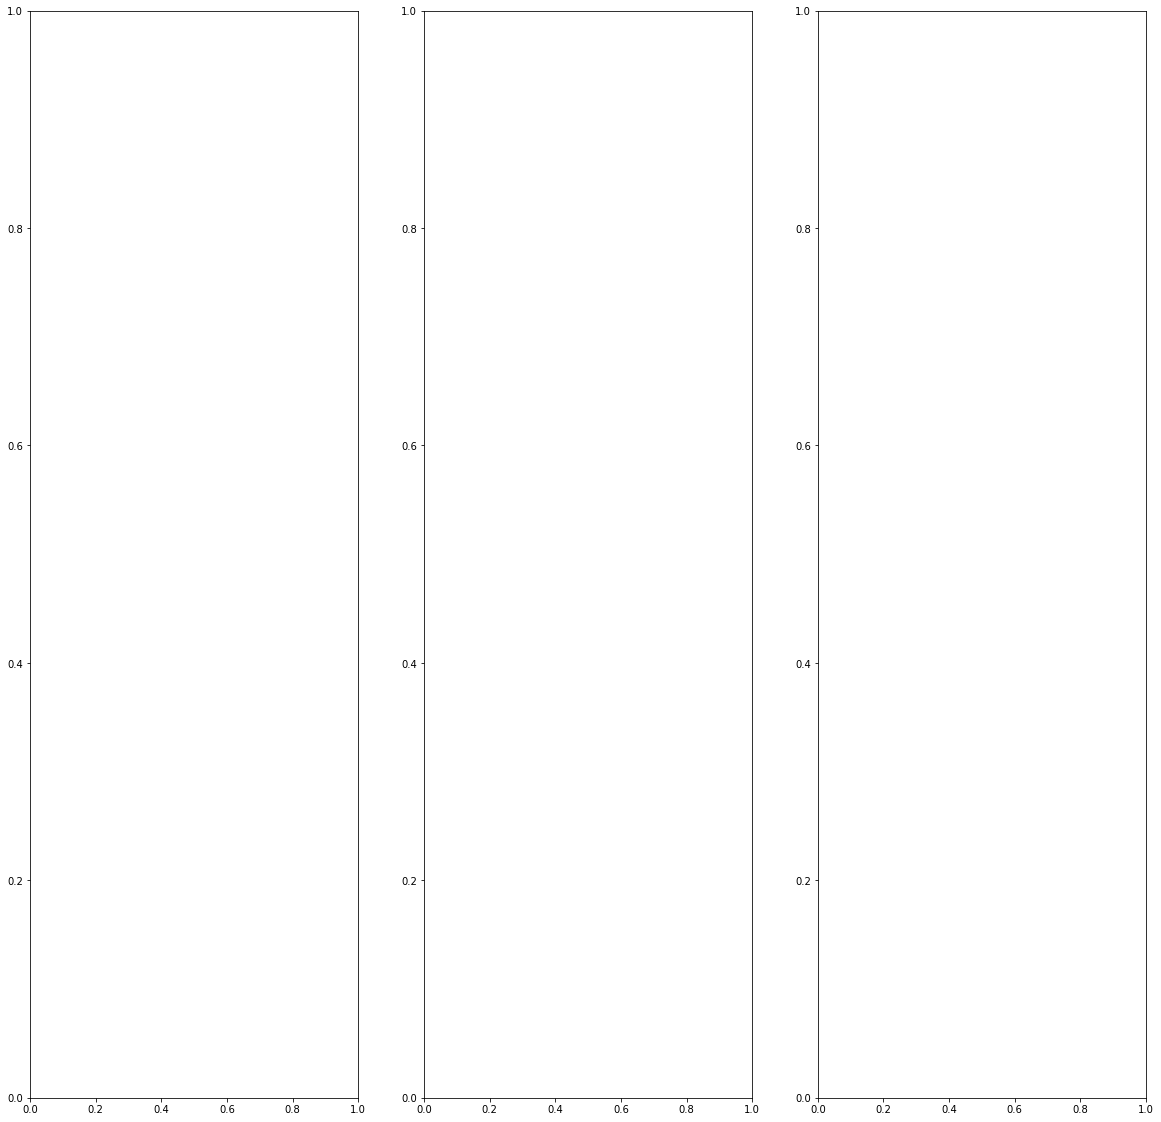

In [8]:
import matplotlib.pyplot as plt

for k in range(1,500,50):
    fig, ax = plt.subplots(1,3,figsize=(20,20))
    ax[0].imshow(storage["imgs"][k])

In [ ]:
storage={} #holder for future pytables
block_shape= np.array((patch_size,patch_size,3))

filters=tables.Filters(complevel=6, complib='zlib') #we can also specify filters, such as compression, to improve storage speed

for phase in phases.keys(): #now for each of the phases, we'll loop through the files
    print(phase)
    files = [all_files[k] for k in phases[phase]]
    
    rscs = [[] for i in range(0,len(files))]    

    osis = [wsi.wsi(img_fname = file, xml_fname = file.split('.tif')[0]+'.xml') for file in files]

    totals=np.zeros(len(class_names)) # we can to keep counts of all the classes in for in particular training, since we 

    for index, wsi_img in tqdm.tqdm(enumerate(osis)):        

        stride_size_converted = wsi_img.get_coord_at_mpp(stride_size,input_mpp=wsi_img["mpps"][0],output_mpp=desired_mask_mpp)

        [mask_small, resize_factor] = wsi_img.mask_out_annotation(desired_mpp=desired_mask_mpp,colors_to_use=None)            

        mask_small = mask_small[list(range(0,np.shape(mask_small)[0],stride_size_converted)),:]            
        mask_small = mask_small[:,list(range(0,np.shape(mask_small)[1],stride_size_converted))]            

        [rs,cs]=(mask_small>0).nonzero()
        rs = [r*stride_size_converted for r in rs]
        cs = [c*stride_size_converted for c in cs]

        rs = [wsi_img.get_coord_at_mpp(r,wsi_img["mpps"][0],desired_mask_mpp) for r in rs]
        cs = [wsi_img.get_coord_at_mpp(c,wsi_img["mpps"][0],desired_mask_mpp) for c in cs]

        goods = np.ones(np.shape(rs)[0])
        for k in range(0,np.shape(rs)[0]):

            a = wsi_img.get_tile(coords=(cs[k],rs[k]),wh=(1,1),desired_mpp=desired_mask_mpp)
            if(np.all(a>220)):
                goods[k] = False             

        cs = [c for idx,c in enumerate(cs) if goods[idx]]
        rs = [r for idx,r in enumerate(rs) if goods[idx]]
        rscs[index]=(cs,rs)            
        
        classid = grade_key[wsi_img['img_fname'].split('/')[-1]]
        totals[classid]+=1


    patch_counts = [np.shape(k)[1] for k in rscs]        
#     patch_counts[0] = patch_counts[0] - 1   
    adds = [1] + patch_counts
    adds = np.cumsum(adds)
#     storage["img"] = np.ones([sum(patch_counts),patch_size,patch_size,3],dtype=np.uint8)
#     storage["mask"] = np.ones([sum(patch_counts),patch_size,patch_size],dtype=np.uint8)

    for index, wsi_img in tqdm.tqdm(enumerate(osis)):
        img_label = grade_key[wsi_img['img_fname'].split('/')[-1]]
        for rcidx in range(0,patch_counts[index]-1,100):            

            img = wsi_img.get_tile(desired_mpp=model_mpp,coords=(rscs[index][0][rcidx],rscs[index][1][rcidx]),wh=(patch_size,patch_size))        
            print(wsi_img['img_fname'].split('/')[-1])
            print(img_label)
            plt.imshow(img)
            plt.show()

In [ ]:
for index, wsi_img in tqdm.tqdm(enumerate(osis)):
        img_label = grade_key[wsi_img['img_fname'].split('/')[-1]]
        for rcidx in range(0,patch_counts[index]-1,100):            

            img = wsi_img.get_tile(desired_mpp=model_mpp,coords=(rscs[index][0][rcidx],rscs[index][1][rcidx]),wh=(patch_size,patch_size))        
            print(wsi_img['img_fname'].split('/')[-1])
            print(img_label)
            plt.imshow(img)
            plt.show()

useful reference
http://machinelearninguru.com/deep_learning/data_preparation/hdf5/hdf5.html